# # CONFIG INICIAL
# Ajusta la ruta del dataset si es necesario.



In [7]:
import os
import sys
from xgboost.callback import EarlyStopping

RANDOM_STATE = 42
CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.join(CURRENT_PATH, "retail_price.csv")  # Cambia si tu archivo está en otra ruta
MODEL_DIR = "./models"

os.makedirs(MODEL_DIR, exist_ok=True)

# Comprobación rápida de existencia del dataset
if not os.path.exists(DATA_PATH):
    print(f"ADVERTENCIA: No se encontró el dataset en {DATA_PATH}. Asegúrate de ajustar DATA_PATH.")
else:
    print("Dataset encontrado:", DATA_PATH)



Dataset encontrado: c:\Documentos\Universidad\Salon 141\Sistemas Inteligentes\PF\retail_price.csv


# # 1) IMPORTS GLOBALES
# Cargamos librerías que usaremos durante todo el notebook.



In [8]:
#.venv/Scripts/Activate.ps1
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import xgboost as xgb
import category_encoders as ce

sns.set(style="whitegrid")



# # 2) UTILIDADES
# Métricas, funciones de guardado/carga, función para simulación de precios (recomendador simple) y otras utilidades.



In [9]:
# Métricas de regresión
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "r2": r2}

# Función para simular precios y elegir mejor precio por ingreso
def simulate_price_recommendation(model, df_row, price_col='unit_price', price_grid=None, encoder=None, features=None):
    """Simula distintos precios, predice qty y recomienda el precio que maximiza revenue.
    Returns dataframe with price, predicted_qty, predicted_revenue, recommended_price.
    encoder: encoder to apply to categorical columns if needed (optional)
    features: feature list used by model
    """
    if price_grid is None:
        # probar -20% a +20% en pasos de 2%
        price_grid = np.round(df_row[price_col].values[0] * (1 + np.arange(-0.2, 0.22, 0.02)), 4)
    rows = []
    base = df_row.copy()
    for p in price_grid:
        r = base.copy()
        r.loc[:, price_col] = p
        # aplicar encoder si existe
        if encoder is not None and hasattr(encoder, 'transform'):
            # asumimos que encoder transforma solo columnas categóricas en su lugar
            try:
                cat_cols = encoder.cols
                r[cat_cols] = encoder.transform(r[cat_cols])
            except Exception:
                pass
        Xpred = r[features]
        qty_pred = model.predict(Xpred)[0]
        revenue_pred = qty_pred * p
        rows.append({'price': p, 'predicted_qty': float(qty_pred), 'predicted_revenue': float(revenue_pred)})
    sim_df = pd.DataFrame(rows)
    best_row = sim_df.loc[sim_df['predicted_revenue'].idxmax()]
    return sim_df, float(best_row['price']) # type: ignore

# Guardar y cargar artefactos
def save_artifact(obj, name):
    path = os.path.join(MODEL_DIR, name)
    joblib.dump(obj, path)
    print('Guardado:', path)

def load_artifact(name):
    path = os.path.join(MODEL_DIR, name)
    return joblib.load(path)



# # 3) CARGA DEL DATASET Y EDA (Análisis Exploratorio de Datos)



In [10]:
# Carga
df = pd.read_csv(DATA_PATH)
print('Dimensiones:', df.shape)
df.head()



Dimensiones: (676, 30)


,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


# # 3.1 Información general y limpieza inicial



In [11]:
# Información y tipos
print(df.info())
print('\nDescripción numérica:')
print(df.describe().T)

# Convertir month_year si está presente
if 'month_year' in df.columns:
    df['month_year'] = pd.to_datetime(df['month_year'], dayfirst=True, errors='coerce')
    df['month'] = df['month_year'].dt.month
    df['year'] = df['month_year'].dt.year

# Limpiar strings
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

# Valores nulos por columna
nulls = df.isnull().sum().sort_values(ascending=False)
print('\nNulos por columna:')
print(nulls[nulls>0])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

# # 3.2 Visualizaciones EDA rápidas



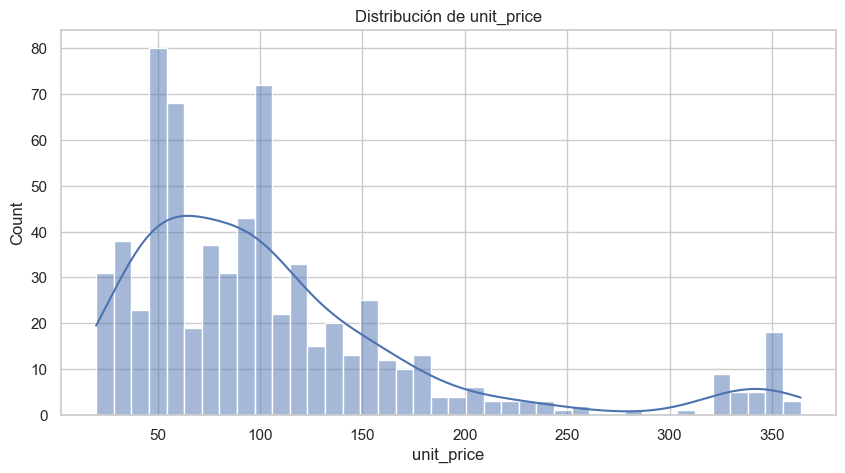

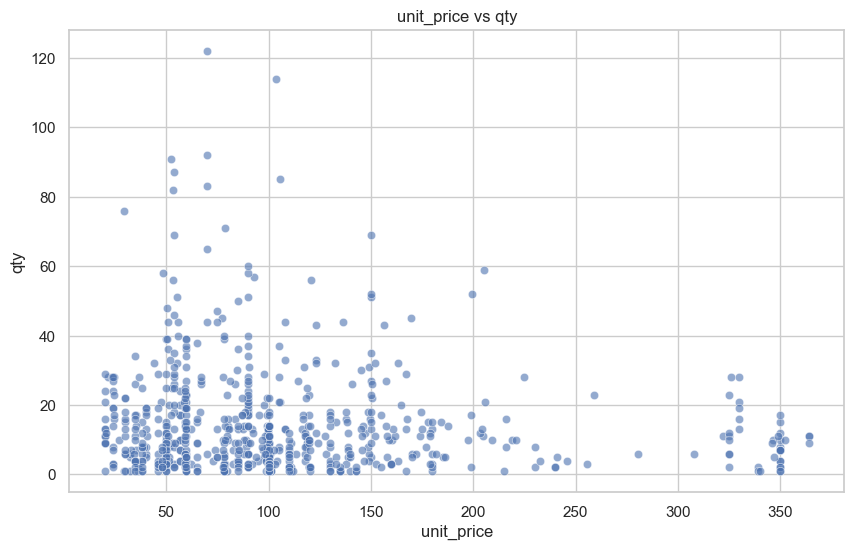

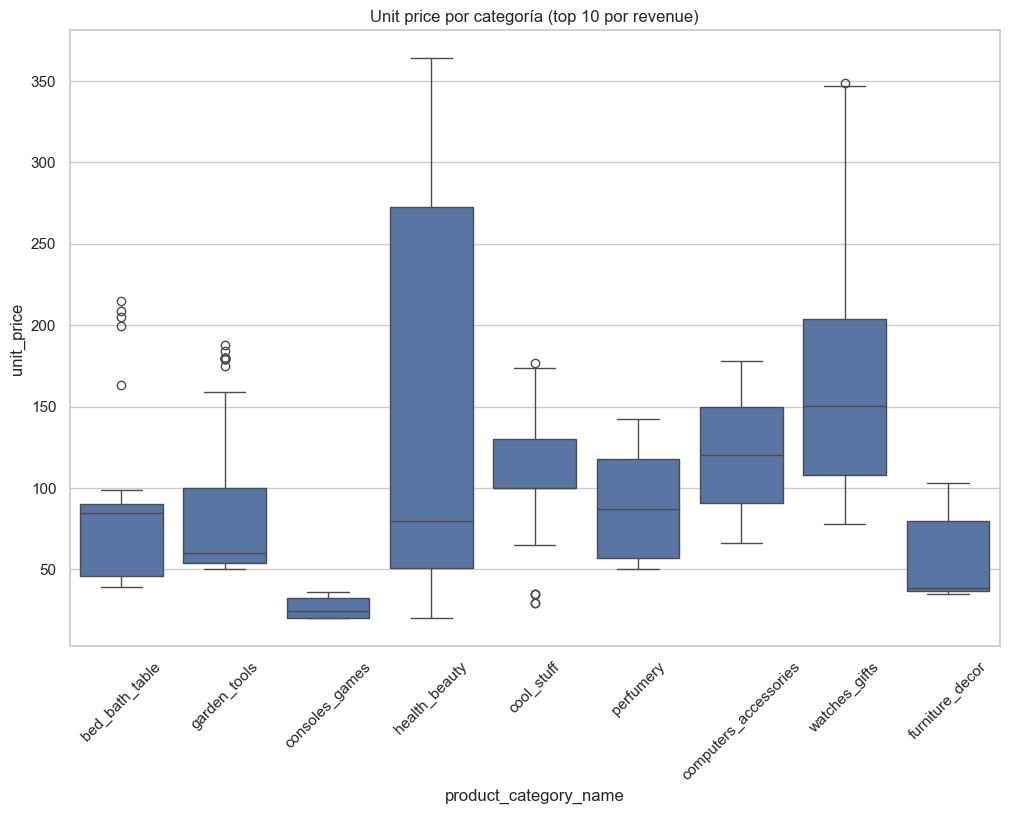

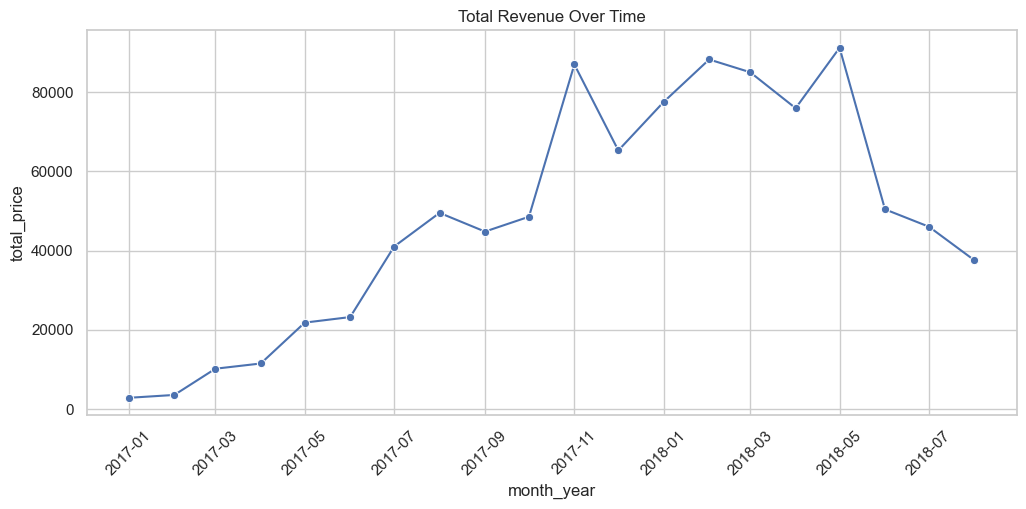

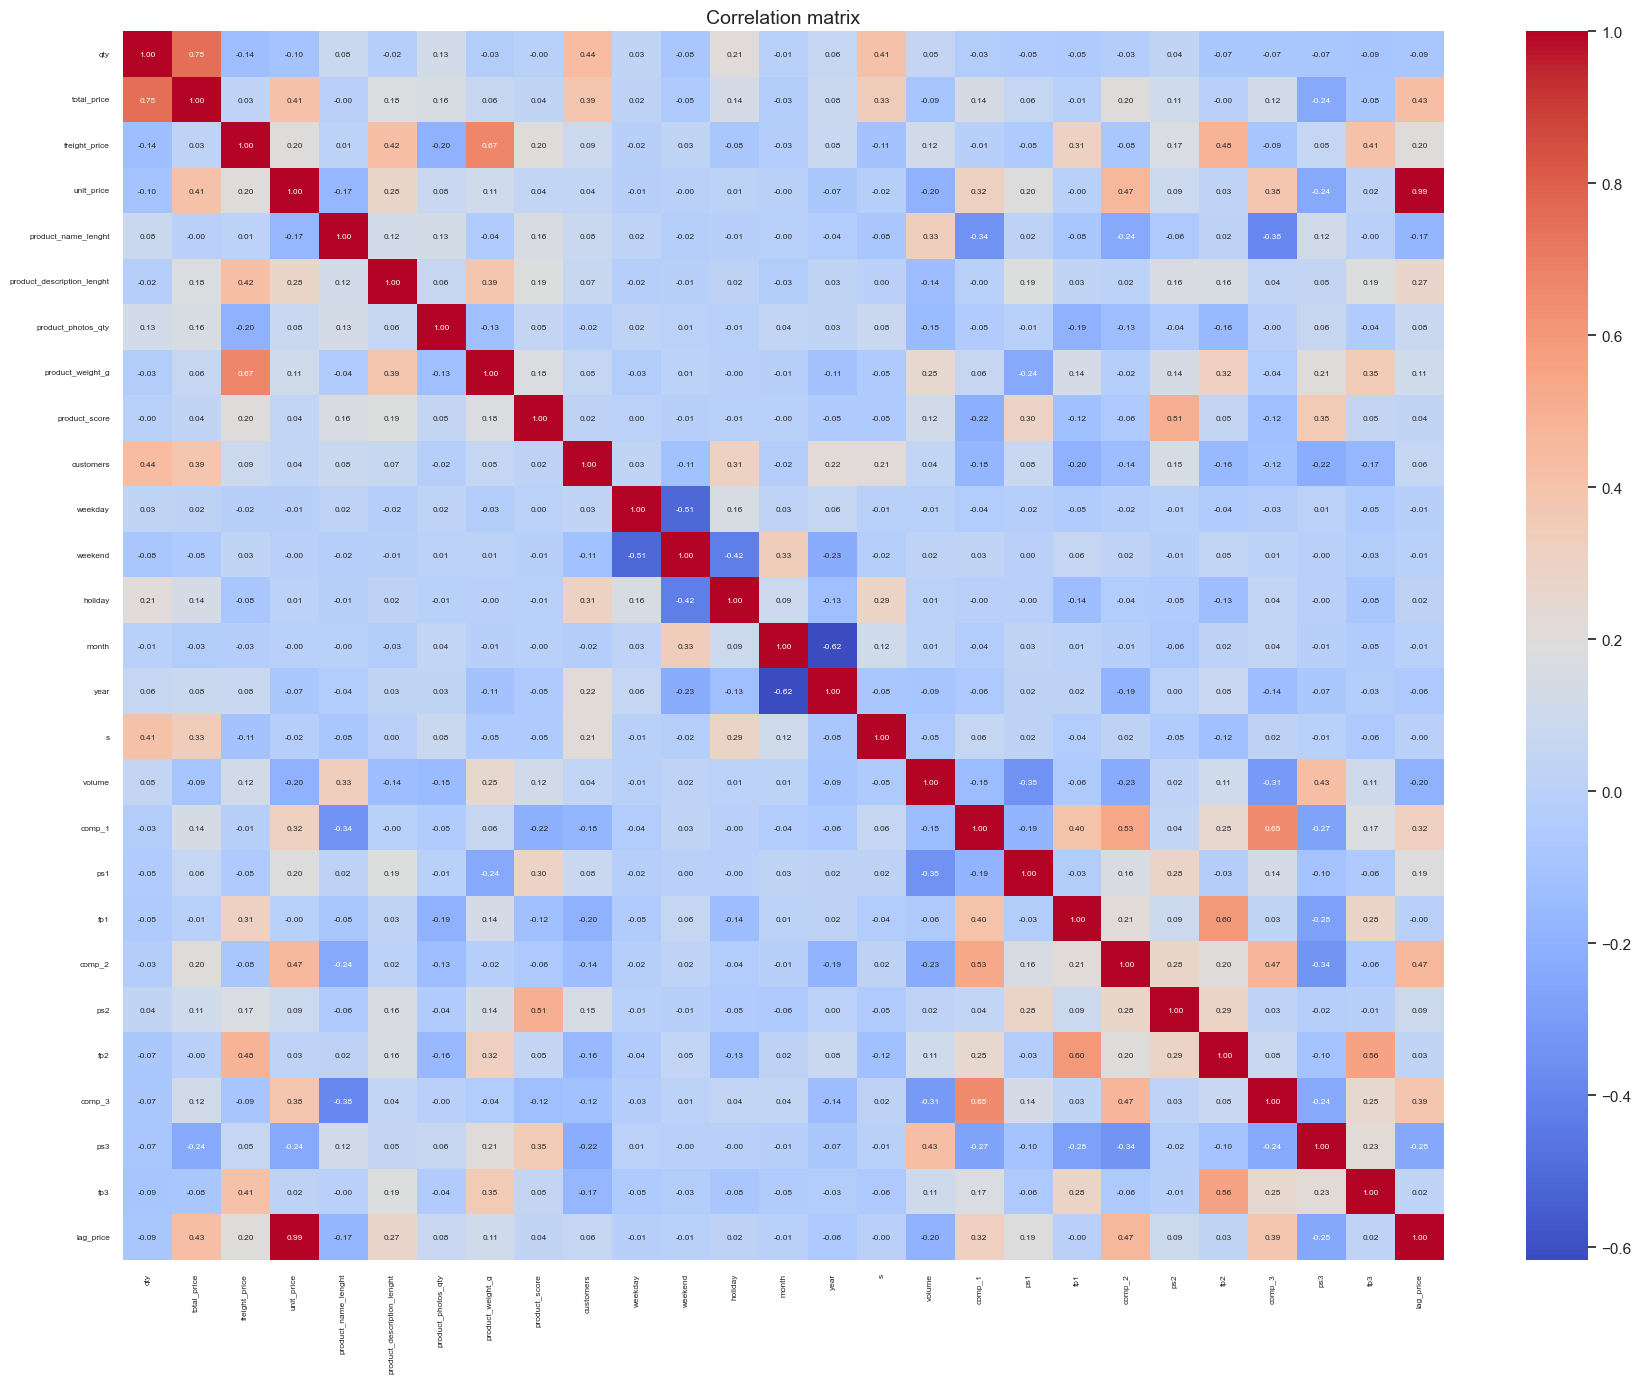

In [12]:
# Histograma unit_price
if 'unit_price' in df.columns:
    plt.figure(figsize=(10,5))
    sns.histplot(df['unit_price'], bins=40, kde=True) # type: ignore
    plt.title('Distribución de unit_price')
    plt.show()

# Scatter unit_price vs qty
if set(['unit_price', 'qty']).issubset(df.columns):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='unit_price', y='qty', data=df, alpha=0.6)
    plt.title('unit_price vs qty')
    plt.show()

# Boxplot por categoría (top 10 categorias por venta)
if 'product_category_name' in df.columns and 'unit_price' in df.columns:
    top_cats = df.groupby('product_category_name')['total_price'].sum().nlargest(10).index
    plt.figure(figsize=(12,8))
    sns.boxplot(x='product_category_name', y='unit_price', data=df[df['product_category_name'].isin(top_cats)])
    plt.xticks(rotation=45)
    plt.title('Unit price por categoría (top 10 por revenue)')
    plt.show()

# Revenue trend
if 'month_year' in df.columns and 'total_price' in df.columns:
    monthly_revenue = df.groupby('month_year')['total_price'].sum().reset_index()
    plt.figure(figsize=(12,5))
    sns.lineplot(x='month_year', y='total_price', data=monthly_revenue, marker='o')
    plt.title('Total Revenue Over Time')
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap (num cols)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
keep_for_corr = [c for c in num_cols if df[c].nunique()>1]
if len(keep_for_corr) > 1:
    plt.figure(figsize=(18,14))  # figura más grande
    sns.heatmap(df[keep_for_corr].corr(), annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 6})  # anotaciones más pequeñas

    plt.title('Correlation matrix', fontsize=14)
    plt.xticks(fontsize=6, rotation=90)  # texto más pequeño y vertical
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

# Treemap de revenue por categoria con plotly
if 'product_category_name' in df.columns and 'total_price' in df.columns:
    cat_sales = df.groupby('product_category_name')['total_price'].sum().reset_index()
    fig = px.treemap(cat_sales.sort_values('total_price', ascending=False).head(30), path=['product_category_name'], values='total_price', title='Top Categories by Revenue')
    fig.show()



# # 4) PREPROCESAMIENTO Y FEATURE ENGINEERING



In [13]:
# 4.1 Relleno de nulos: estrategia simple (puedes mejorar)

df_proc = df.copy()
num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns.tolist()

# Rellenar numéricos por mediana
for c in num_cols:
    if df_proc[c].isnull().any():
        df_proc[c].fillna(df_proc[c].median(), inplace=True)
# Rellenar categóricos por '__missing__'
for c in cat_cols:
    if df_proc[c].isnull().any():
        df_proc[c].fillna('__missing__', inplace=True)

# Feature engine: revenue, weight_kg
if 'unit_price' in df_proc.columns and 'qty' in df_proc.columns:
    df_proc['revenue'] = df_proc['unit_price'] * df_proc['qty']
if 'product_weight_g' in df_proc.columns:
    df_proc['weight_kg'] = df_proc['product_weight_g']/1000.0

# Eliminar filas con target nulo
TARGET = 'qty'
df_proc = df_proc[~df_proc[TARGET].isnull()].reset_index(drop=True)

print('Después preproc:', df_proc.shape)



Después preproc: (676, 32)


# # 4.2 Selección de features (heurística)



In [14]:
# Excluir columnas que no usaremos
exclude = ['month_year']  # añade columnas irrelevantes si las hay
features = [c for c in df_proc.columns if c not in exclude + [TARGET]]
print('Número features candidatos:', len(features))
print(features[:40])



Número features candidatos: 30
['product_id', 'product_category_name', 'total_price', 'freight_price', 'unit_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month', 'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'lag_price', 'revenue', 'weight_kg']


# # 5) SPLIT: Train / Validation / Test
# Recomendación: si hay dependencia temporal usar TimeSeriesSplit o dividir por fecha.



In [15]:
if 'month_year' in df_proc.columns and df_proc['month_year'].notnull().all():
    # split temporal: entrenar con los meses más antiguos
    df_proc = df_proc.sort_values('month_year').reset_index(drop=True)
    n = len(df_proc)
    train_end = int(n*0.7)
    val_end = int(n*0.85)
    train_df = df_proc.iloc[:train_end].copy()
    val_df = df_proc.iloc[train_end:val_end].copy()
    test_df = df_proc.iloc[val_end:].copy()
    print('Temporal split ->', train_df.shape, val_df.shape, test_df.shape)
else:
    # split aleatorio
    train_val, test_df = train_test_split(df_proc, test_size=0.15, random_state=RANDOM_STATE)
    train_df, val_df = train_test_split(train_val, test_size=0.1765, random_state=RANDOM_STATE)  # 0.1765 * 0.85 ~= 0.15
    print('Random split ->', train_df.shape, val_df.shape, test_df.shape)



Temporal split -> (473, 32) (101, 32) (102, 32)


# # 6) ENCODING: Target/Mean Encoding (sin leakage)



In [16]:
# Elegimos columnas categóricas a codificar
categorical_cols = [c for c in cat_cols if c in features]
print('Categorical cols:', categorical_cols)

# Ajustar TargetEncoder en training (smoothing por defecto)
te = ce.TargetEncoder(cols=categorical_cols, smoothing=0.3)
te.fit(train_df[categorical_cols], train_df[TARGET])

# Transformar
train_enc = train_df.copy()
val_enc = val_df.copy()
test_enc = test_df.copy()

if len(categorical_cols) > 0:
    train_enc[categorical_cols] = te.transform(train_df[categorical_cols])
    val_enc[categorical_cols] = te.transform(val_df[categorical_cols])
    test_enc[categorical_cols] = te.transform(test_df[categorical_cols])

# Definir X,y
X_train = train_enc[features].copy()
y_train = train_enc[TARGET].copy()
X_val = val_enc[features].copy()
y_val = val_enc[TARGET].copy()
X_test = test_enc[features].copy()
y_test = test_enc[TARGET].copy()

print('Shapes X_train, X_val, X_test ->', X_train.shape, X_val.shape, X_test.shape)



Categorical cols: ['product_id', 'product_category_name']
Shapes X_train, X_val, X_test -> (473, 30) (101, 30) (102, 30)


# # 7) ENTRENAMIENTO DEL MODELO PRINCIPAL: XGBoost



In [17]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='rmse'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)


[0]	validation_0-rmse:14.62654	validation_1-rmse:19.19997
[50]	validation_0-rmse:2.40279	validation_1-rmse:8.36337
[100]	validation_0-rmse:0.73776	validation_1-rmse:6.01371
[150]	validation_0-rmse:0.33201	validation_1-rmse:5.46129
[200]	validation_0-rmse:0.18885	validation_1-rmse:5.31895
[250]	validation_0-rmse:0.12280	validation_1-rmse:5.27964
[300]	validation_0-rmse:0.08079	validation_1-rmse:5.26475
[350]	validation_0-rmse:0.05389	validation_1-rmse:5.25868
[400]	validation_0-rmse:0.03577	validation_1-rmse:5.25576
[450]	validation_0-rmse:0.02373	validation_1-rmse:5.25407
[500]	validation_0-rmse:0.01557	validation_1-rmse:5.25318
[550]	validation_0-rmse:0.01037	validation_1-rmse:5.25277
[600]	validation_0-rmse:0.00710	validation_1-rmse:5.25243
[650]	validation_0-rmse:0.00485	validation_1-rmse:5.25210
[700]	validation_0-rmse:0.00320	validation_1-rmse:5.25189
[750]	validation_0-rmse:0.00213	validation_1-rmse:5.25180
[800]	validation_0-rmse:0.00146	validation_1-rmse:5.25177
[850]	validatio

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


# # 8) MODELO SECUNDARIO: RandomForest (validación)



In [18]:
rf = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics_rf = regression_metrics(y_test, y_pred_rf)
print('RandomForest test metrics:', metrics_rf)
save_artifact(rf, 'rf_model.joblib')



RandomForest test metrics: {'rmse': np.float64(1.7209729920064656), 'mae': 0.8846078431372548, 'r2': 0.9683978149036983}
Guardado: ./models\rf_model.joblib


# # 9) IMPORTANCIA DE FEATURES Y ANÁLISIS



Top features XGBoost:
                       feature  importance
28                     revenue    0.461071
4                   unit_price    0.144147
2                  total_price    0.114559
27                   lag_price    0.093958
21                      comp_2    0.053710
1        product_category_name    0.032859
24                      comp_3    0.011410
7           product_photos_qty    0.011194
16                           s    0.009072
10                   customers    0.009060
19                         ps1    0.009004
0                   product_id    0.007771
3                freight_price    0.005427
14                       month    0.005191
6   product_description_lenght    0.004332


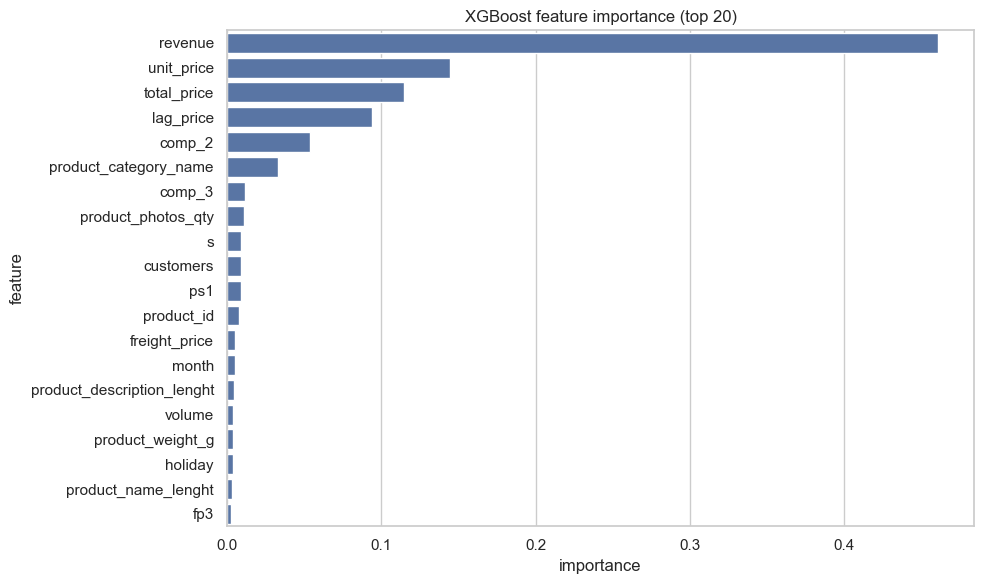

Top features RF:
                       feature  importance
28                     revenue    0.329892
2                  total_price    0.296275
4                   unit_price    0.205804
27                   lag_price    0.071134
1        product_category_name    0.013369
21                      comp_2    0.011788
16                           s    0.011069
10                   customers    0.008983
23                         fp2    0.006140
25                         ps3    0.005795
26                         fp3    0.004431
14                       month    0.003144
6   product_description_lenght    0.003132
24                      comp_3    0.003118
3                freight_price    0.002883


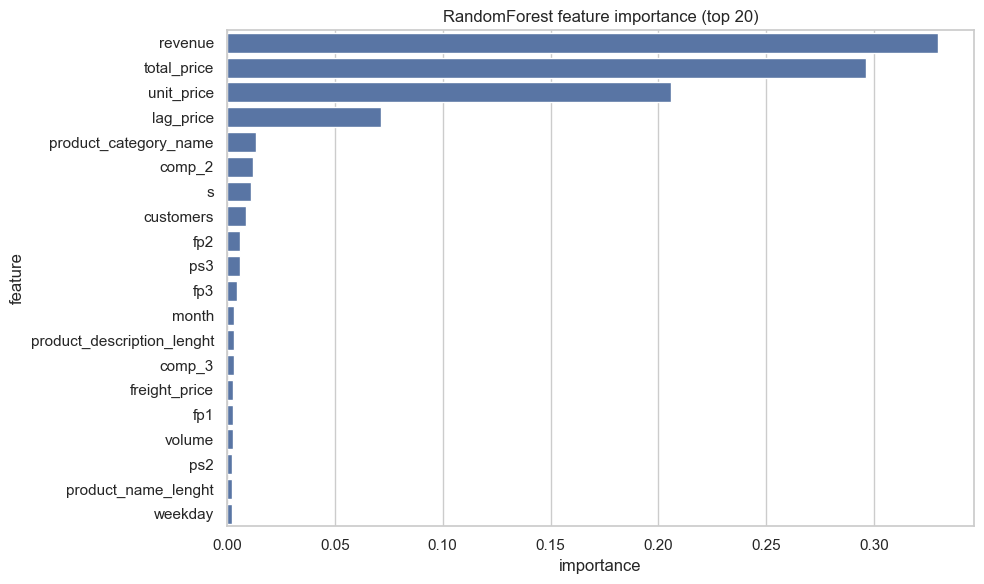

In [19]:
# XGBoost importance
fi_xgb = pd.DataFrame({'feature': X_train.columns, 'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False)
print('Top features XGBoost:')
print(fi_xgb.head(15))

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_xgb.head(20))
plt.title('XGBoost feature importance (top 20)')
plt.tight_layout()
plt.show()

# RandomForest importance
fi_rf = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print('Top features RF:')
print(fi_rf.head(15))

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_rf.head(20))
plt.title('RandomForest feature importance (top 20)')
plt.tight_layout()
plt.show()



# # 10) SHAP: explicabilidad detallada




In [20]:
import time

start = time.time()
import shap
shap.initjs()
print(f"✅ SHAP importado en {time.time() - start:.1f} segundos")


✅ SHAP importado en 0.3 segundos


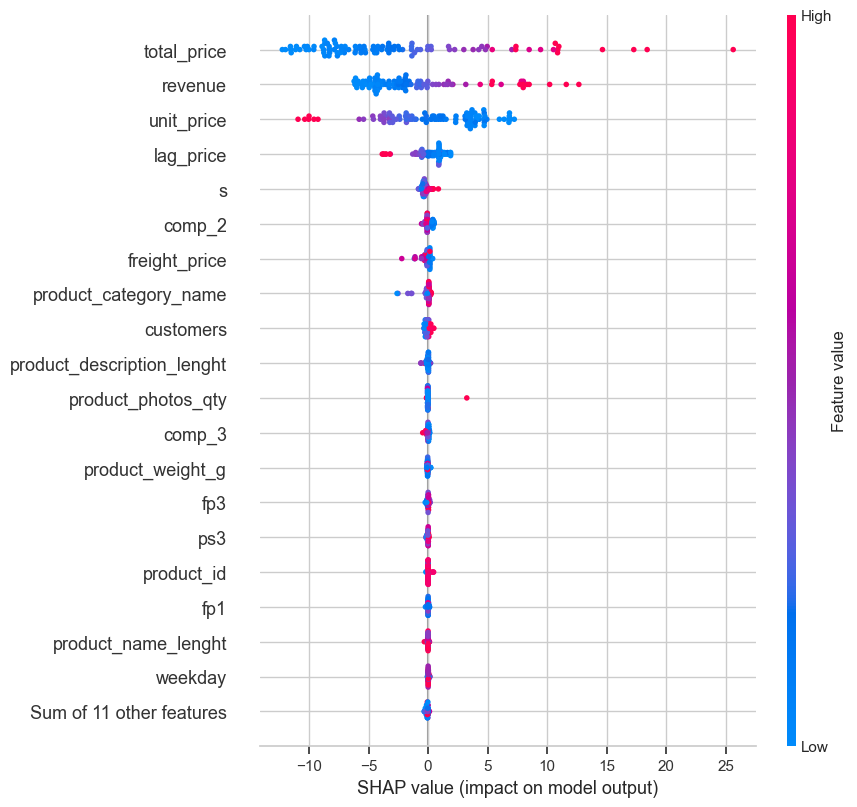


Dependence plot: revenue


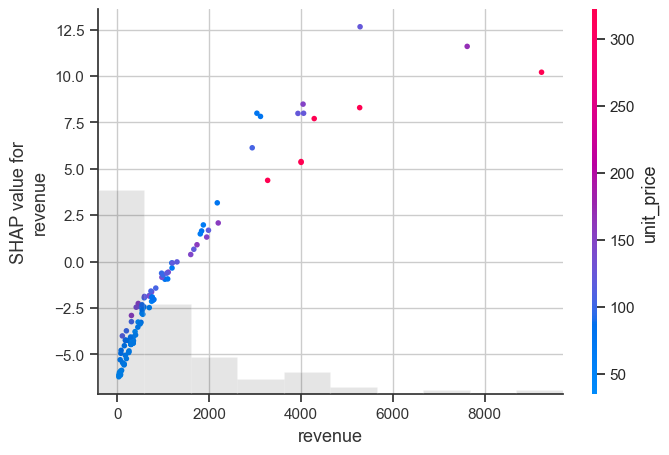


Dependence plot: unit_price


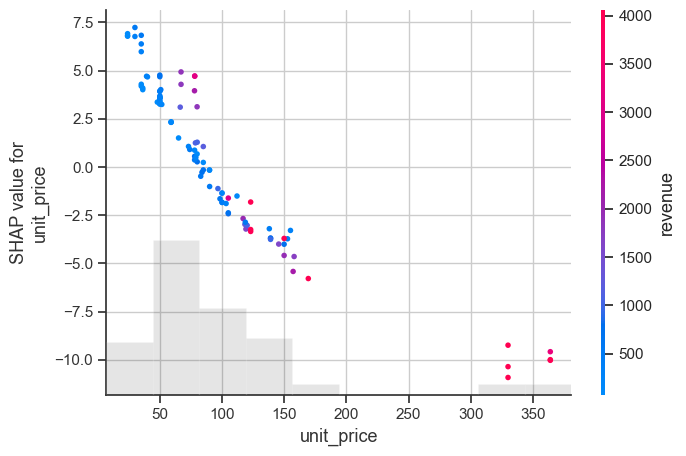


Dependence plot: total_price


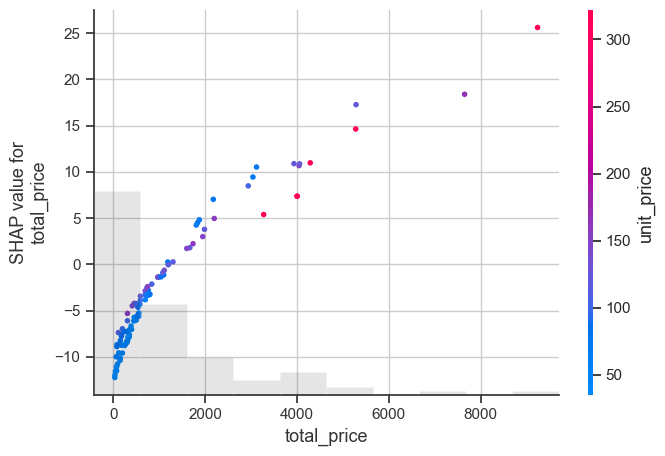

Guardado: ./models\shap_explainer.joblib


In [21]:
# Crear explainer (TreeExplainer internamente optimizado)
explainer = shap.Explainer(xgb_model)
X_shap_sample = X_test.sample(n=min(2000, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer(X_shap_sample)

# Summary plot
shap.plots.beeswarm(shap_values, max_display=20)

# Dependence plots para top 3
top3 = fi_xgb['feature'].head(3).tolist()
for f in top3:
    print('\nDependence plot:', f)
    shap.plots.scatter(shap_values[:, X_shap_sample.columns.get_loc(f)], color=shap_values)

# Guardar shap values (opcional)
save_artifact(explainer, 'shap_explainer.joblib')



# ## 11) CLUSTERING (opcional) — segmentación para personalización



In [22]:
# Usamos KMeans sobre features numéricos (transformed)
scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_train.fillna(0))

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
kmeans.fit(X_cluster)

# Añadir cluster al dataset de train
train_enc['cluster'] = kmeans.predict(scaler.transform(X_train.fillna(0)))
print('Tamaño por cluster (train):')
print(train_enc['cluster'].value_counts())

save_artifact(scaler, 'scaler_for_clustering.joblib')
save_artifact(kmeans, 'kmeans_model.joblib')



Tamaño por cluster (train):
cluster
0    189
1    138
3    122
2     24
Name: count, dtype: int64
Guardado: ./models\scaler_for_clustering.joblib
Guardado: ./models\kmeans_model.joblib


In [27]:
import xgboost as xgb
import joblib

# Supongamos que el modelo xgb_model está entrenado
# Guardar el modelo con joblib
joblib.dump(xgb_model, 'xgb_model.joblib')


['xgb_model.joblib']

# ## 12) MÓDULO DE RECOMENDACIONES + JUSTIFICACIÓN
# Implementamos una función que, para una fila de producto (o caso), simula precios y sugiere el que maximiza revenue.
# Además, genera una justificación basada en SHAP (valores que más influyen) y en la simulación de elasticidad.



In [23]:
# ==========================
# RECOMMENDACIÓN DE PRECIO
# ==========================
FEATURES = X_train.columns.tolist()

def recommend_price_and_explain(
    row_original, 
    model=xgb_model, 
    encoder=te, 
    features=FEATURES, 
    price_col='unit_price'
):
    """
    Recibe un DataFrame de 1 fila con las columnas originales
    y devuelve recomendación de precio + explicación.
    Funciona aunque falten columnas.
    """

    # Copia segura
    row = row_original.copy()

    # --- RECREAR FEATURES ENGINEERED EXACTAMENTE COMO EL PREPROCESSING ---
    # Revenue
    if 'unit_price' in row.columns and 'qty' in row.columns and 'revenue' in features:
        row['revenue'] = row['unit_price'] * row['qty']

    # Peso en kg
    if 'product_weight_g' in row.columns and 'weight_kg' in features:
        row['weight_kg'] = row['product_weight_g'] / 1000.0

    # --- RELLENAR COLUMNAS QUE FALTEN PARA EL MODELO ---
    for c in features:
        if c not in row.columns:
            row[c] = np.nan

    # --- RELLENO DE NULOS (MISMA LÓGICA DEL PREPROC) ---
    for c in num_cols:
        if c in row.columns:
            row[c] = row[c].fillna(df[c].median())

    for c in cat_cols:
        if c in row.columns:
            row[c] = row[c].fillna('__missing__')

    # --- ENCODING CATEGÓRICO ---
    if len(categorical_cols) > 0:
        try:
            row[categorical_cols] = encoder.transform(row[categorical_cols])
        except:
            pass

    # --- PREDICCIÓN A PRECIO ACTUAL ---
    Xrow = row[features]
    current_qty = float(model.predict(Xrow)[0])
    current_price = float(row[price_col].values[0])
    current_rev = current_qty * current_price

    # --- SIMULACIÓN DE PRECIOS ---
    sim_df, best_price = simulate_price_recommendation(
        model, row,
        price_col=price_col,
        encoder=encoder,
        features=features
    )

    best_row = sim_df.loc[sim_df['price'] == best_price].iloc[0]

    # --- SHAP LOCAL EXPLANATION ---
    try:
        x_enc = Xrow.fillna(0)
        shap_local = explainer(x_enc)
        shap_vals = shap_local.values[0]
        idx_top = np.argsort(np.abs(shap_vals))[::-1][:5]
        top_features = [(Xrow.columns[i], float(shap_vals[i])) for i in idx_top]
    except:
        top_features = []

    # --- ELASTICIDAD --- (respuesta qty a +/-10% cambio en precio)
    price_up = current_price * 1.1
    price_down = current_price * 0.9

    test_up = row.copy()
    test_down = row.copy()
    test_up[price_col] = price_up
    test_down[price_col] = price_down

    if len(categorical_cols) > 0:
        try:
            test_up[categorical_cols] = encoder.transform(test_up[categorical_cols])
            test_down[categorical_cols] = encoder.transform(test_down[categorical_cols])
        except:
            pass

    qty_up = float(model.predict(test_up[features])[0])
    qty_down = float(model.predict(test_down[features])[0])

    pct_qty = (qty_down - qty_up) / ((qty_down + qty_up) / 2 + 1e-9)
    pct_price = (price_down - price_up) / ((price_down + price_up) / 2 + 1e-9)
    elasticity = pct_qty / (pct_price + 1e-9)

    # --- SALIDA FINAL ---
    return {
        'current_qty': current_qty,
        'current_revenue': current_rev,
        'recommended_price': best_price,
        'recommended_pred_qty': best_row['predicted_qty'],
        'recommended_pred_revenue': best_row['predicted_revenue'],
        'top_shap_features': top_features,
        'elasticity_approx': elasticity,
        'simulation_table': sim_df
    }


# # 13) INTERFAZ DE USUARIO — CUSTOMTKINTER

In [28]:
###############################################
#   INTERFAZ GRÁFICA COMPLETA (CustomTkinter)
###############################################

import customtkinter as ctk
from tkinter import filedialog, messagebox
import pandas as pd

# ================================
#   MEJOR DISEÑO VISUAL GLOBAL
# ================================
ctk.set_appearance_mode("dark")
ctk.set_default_color_theme("dark-blue")


def launch_gui():

    app = ctk.CTk()
    app.after(100, lambda: app.state("zoomed"))
    app.title("Sistema Inteligente de Recomendación de Precios")
    app.geometry("1100x850")
    app.configure(fg_color="#0E141A")
    app.df_local = None # type: ignore

    def cerrar(event=None):
        app.destroy()

    app.bind("<q>", cerrar)
    app.bind("<Q>", cerrar)
    app.protocol("WM_DELETE_WINDOW", cerrar)

    # ===================================================
    #                FUNCIONES INTERNAS
    # ===================================================

     # Ejecutar cuando el CSV se cargue
    def load_csv_action():
        file = filedialog.askopenfilename(filetypes=[("CSV", "*.csv")])
        if file:
            try:
                df = pd.read_csv(file)
                app.df_local = df # type: ignore
                messagebox.showinfo("Éxito", f"CSV cargado ({len(df)} filas)")
                update_category_list()   # ← llenar el scrollbar
            except Exception as e:
                messagebox.showerror("Error", f"No se pudo cargar el CSV:\n{e}")
                
    def run_recommendation_action():
        if app.df_local is None: # type: ignore
            messagebox.showerror("Error", "Primero cargue un archivo CSV.")
            return

        # 1. Validar categoría
        category = selected_category.get()
        if category.strip() == "":
            messagebox.showerror("Error", "Seleccione una categoría.")
            return

        # 2. Validar precio unitario ingresado
        try:
            price_input = float(entry_price.get())
        except:
            messagebox.showerror("Error", "Ingrese un precio válido.")
            return

        # 3. Crear fila artificial usando promedio de la categoría
        df_cat = app.df_local[app.df_local["product_category_name"] == category] # type: ignore

        if df_cat.empty:
            messagebox.showerror("Error", "No existen datos suficientes de esa categoría.")
            return

        row = df_cat.iloc[[0]].copy()
        row["unit_price"] = price_input  # precio ingresado por usuario

        # 4. Ejecutar recomendación
        try:
            result = recommend_price_and_explain(row)
        except Exception as e:
            rec_text.configure(state="normal")
            rec_text.delete("1.0", "end")
            rec_text.insert("1.0", f"ERROR:\n{e}")
            rec_text.configure(state="disabled")
            return

    # ===============================  
    # MOSTRAR RESULTADOS  
    # ===============================  

    # ---- RECOMENDACIÓN ----
        rec_text.configure(state="normal")
        rec_text.delete("1.0", "end")
        rec_text.insert("1.0", f" Categoría: {category}\n"
                            f" Precio ingresado: ${price_input:.2f}\n"
                            f" Precio recomendado: ${result['recommended_price']:.2f}")
        rec_text.configure(state="disabled")

        # ---- DEMANDA ----
        dem_text.configure(state="normal")
        dem_text.delete("1.0", "end")
        dem_text.insert("1.0", f" Unidades esperadas: {result['recommended_pred_qty']:.2f}\n"
                            f" Ingreso estimado: ${result['recommended_pred_revenue']:.2f}")
        dem_text.configure(state="disabled")

        # ---- ELASTICIDAD ----
        ela_text.configure(state="normal")
        ela_text.delete("1.0", "end")
        ela_text.insert("1.0", f" Elasticidad aproximada: {result['elasticity_approx']:.4f}")
        ela_text.configure(state="disabled")

        # ---- SHAP ----
        shap_text.configure(state="normal")
        shap_text.delete("1.0", "end")
        shap_string = "\n".join(f" • {f}: {v:.4f}" for f, v in result["top_shap_features"])
        shap_text.insert("1.0", shap_string)
        shap_text.configure(state="disabled")

        # ---- JUSTIFICACIÓN COMPLETA ----
        full_text = f"{build_justification(result, category)}"
        lbl_right.configure(state="normal")
        lbl_right.delete("1.0", "end")
        lbl_right.insert("1.0", full_text)
        lbl_right.configure(state="disabled")

        #Nuevo
        
        #Fin Nuevp


    def build_justification(result, category):

        price = result["recommended_price"]
        qty = result["recommended_pred_qty"]
        revenue = result["recommended_pred_revenue"]
        elasticity = result["elasticity_approx"]
        shap = result["top_shap_features"]

        if elasticity < -1:
            e_text = "muy sensible al precio"
        elif elasticity < -0.5:
            e_text = "moderadamente sensible"
        elif elasticity < -0.1:
            e_text = "poco sensible"
        else:
            e_text = "prácticamente inelástica"

        # -----------------------------------------------------------
        # INTERPRETACIÓN PERSONALIZADA DE LA DEMANDA ESTIMADA
        # -----------------------------------------------------------
        if qty < 5:
            dem_msg = (
            "La demanda estimada es muy baja. Esto suele indicar que el producto es especialmente sensible al precio "
            "o que el mercado para esta categoría tiene poco movimiento en este periodo."
            )
        elif qty < 20:
            dem_msg = (
            "La demanda esperada es moderada. Representa un comportamiento estable donde el precio recomendado mantiene "
            "un equilibrio razonable entre ventas y ganancia."
            )
        else:
            dem_msg = (
            "La demanda proyectada es alta, lo cual es un excelente indicador. El precio recomendado está en un punto "
            "donde el volumen de ventas puede ser fuerte sin sacrificar rentabilidad."
            )


        # -----------------------------------------------------------
        # INTERPRETACIÓN PERSONALIZADA DE LA ELASTICIDAD
        # -----------------------------------------------------------
        if elasticity < -1.2:
            ela_msg = (
            "Este producto es altamente elástico. Pequeños cambios en el precio generan variaciones fuertes en la demanda. "
            "Los consumidores reaccionan rápidamente ante cualquier ajuste."
            )
        elif elasticity < -0.6:
            ela_msg = (
            "El producto muestra elasticidad considerable. El precio influye de forma notable en la decisión de compra, "
            "pero sin llegar a ser extremo."
            )
        elif elasticity < -0.2:
            ela_msg = (
            "El producto tiene elasticidad moderada. El precio afecta a la demanda, aunque los cambios no son tan drásticos."
            )
        else:
            ela_msg = (
            "El producto es prácticamente inelástico. Los consumidores mantienen su comportamiento aunque el precio varíe."
            )


            # ===========================================================
    # NUEVA SECCIÓN: INTERPRETACIÓN AVANZADA Y PERSONALIZADA DE SHAP
    # ===========================================================
        shap_interpretation = "\n\n                                                       Interpretación avanzada de los Factores SHAP\n\n"

        # Detectamos máximo absoluto para identificar el más fuerte
        max_abs = max(abs(v) for _, v in shap)

        for feature, value in shap:

            abs_v = abs(value)

            # --------------- NIVEL DE IMPACTO ---------------

            if abs_v == max_abs:
                fuerza = "Este es el impacto más fuerte de todos"
            elif abs_v > 7:
                fuerza = "Su efecto es bastante grande"
            elif abs_v > 3:
                fuerza = "Tiene un impacto moderado pero importante"
            elif abs_v > 1:
                fuerza = "Su influencia es perceptible y relevante"
            elif abs_v > 0.3:
                fuerza = "Su efecto es ligero"
            else:
                fuerza = "Su efecto es muy pequeño"

            # --------------- TIPO DE IMPACTO (positivo/negativo) ---------------

            if value < -7:
                tono = "muy negativo"
                explicacion = (
                    "Históricamente, cuando esta variable aumenta, la demanda suele caer fuertemente. "
                    "El modelo interpreta que este valor va en contra del precio que funciona bien."
                )
                implicacion = (
                    "Empuja la predicción hacia reducir la demanda y sugiere que el precio ingresado "
                    "está por encima de lo óptimo."
                )

            elif value < -3:
                tono = "negativo"
                explicacion = (
                    "Este valor indica que la variable tiende a disminuir la demanda en este contexto. "
                    "No es un impacto extremo, pero sí consistente con patrones históricos."
                )
                implicacion = (
                    "El modelo compensa este efecto ajustando el precio recomendado un poco a la baja."
                )

            elif value < -0.8:
                tono = "ligeramente negativo"
                explicacion = (
                    "Sugiere que la situación actual de esta variable no es favorable para sostener "
                    "precios más altos, pero tampoco es un efecto severo."
                )
                implicacion = (
                    "La recomendación final atenúa el precio sugerido para equilibrar este pequeño freno en la demanda."
                )

            elif value < -0.2:
                tono = "muy suave negativo"
                explicacion = (
                    "Indica un pequeño sesgo hacia la reducción de demanda, pero el efecto es débil."
                )
                implicacion = (
                    "Su participación en el precio recomendado es mínima."
                )

            elif value < 0.2:
                tono = "casi neutro"
                explicacion = (
                    "Este factor prácticamente no cambia la demanda. "
                    "En los datos históricos su influencia es marginal."
                )
                implicacion = (
                    "No afecta de manera significativa la decisión del precio recomendado."
                )

            elif value < 1.2:
                tono = "positivo"
                explicacion = (
                    "Este valor indica que la variable ayuda ligeramente a aumentar la demanda. "
                    "Es un empuje favorable pero no dominante."
                )
                implicacion = (
                    "Contribuye a que el modelo no recomiende bajar demasiado el precio."
                )

            elif value < 4:
                tono = "bastante positivo"
                explicacion = (
                    "Refleja que esta variable fortalece la demanda de forma clara. "
                    "Históricamente, cuando este valor crece, el mercado responde bien."
                )
                implicacion = (
                    "Esto actúa como contrapeso ante otros factores negativos."
                )

            else:
                tono = "muy positivo"
                explicacion = (
                    "Este es un impulso grande hacia arriba en la demanda. "
                    "En los datos, esta variable está fuertemente asociada con mejores ventas."
                )
                implicacion = (
                    "Ayuda notablemente a sostener el precio sugerido o incluso subirlo ligeramente."
                )

            # --------------- MENSAJE FINAL ---------------

            shap_interpretation += (
                f"\n• {feature}: {value:.4f} ({tono})\n"
                f"\n{fuerza}.\n\n"
                f"- Interpretación: {explicacion}\n\n"
                f"- ¿Qué implica?: {implicacion}\n\n\n"
            )


        justification = f"""
Esta recomendación se construye a partir del análisis integral del producto dentro
de su categoría "{category}", considerando tanto su comportamiento histórico como la
respuesta esperada del mercado frente a variaciones de precio.

                                                                       
                                                                            Precio recomendado


El sistema sugiere fijar un precio de ${price:.2f}. Este valor equilibra el nivel de demanda esperada con la 
maximización del ingreso proyectado. 

El precio no se elige solo porque sea “alto” o “bajo”, sino porque representa el punto donde la relación 
entre volumen vendido y ganancia estimada es más favorable para este producto.

                                                                   
                                                                   Demanda esperada y su impacto


• Demanda estimada: {qty:.2f} unidades.

{dem_msg} Se proyecta un ingreso aproximado de ${revenue:.2f}. 

                                                               
                                                                         Elasticidad del producto

• Elasticidad del producto: {elasticity:.4f}

{ela_msg}

Este dato es importante porque explica qué tan “delicado” es el mercado con respecto a los cambios de precio.
{shap_interpretation}
""".strip()

        return justification.strip()


    # ===================================================
    #                   WIDGETS
    # ===================================================

    frame = ctk.CTkFrame(app, fg_color="#141E27", corner_radius=20)
    frame.pack(padx=20, pady=20, fill="both", expand=True)

    frame.grid_columnconfigure(0, weight=1)
    frame.grid_rowconfigure(5, weight=1)

    lbl_title = ctk.CTkLabel(
        frame,
        text="Sistema Inteligente de Recomendación de Precios",
        font=("Segoe UI Semibold", 28),
        text_color="#78AFFF"
    )
    lbl_title.grid(row=0, column=0, pady=10)

    btn_load = ctk.CTkButton(
        frame, text="Cargar CSV", command=load_csv_action,
        corner_radius=12, font=("Segoe UI Semibold", 14))
    btn_load.grid(row=1, column=0, pady=5)

    # ===================================================
    # NUEVO PANEL → SELECCIÓN DE CATEGORÍA + PRECIO UNITARIO
    # ===================================================
    category_price_frame = ctk.CTkFrame(frame, fg_color="transparent")
    category_price_frame.grid(row=3, column=0, pady=10)

    # ----------- MENÚ DESPLEGABLE DE CATEGORÍAS -----------
    lbl_cat = ctk.CTkLabel(
        category_price_frame,
        text="Seleccione categoría:",
        font=("Segoe UI Semibold", 14)
    )
    lbl_cat.grid(row=0, column=0, padx=5, pady=(0,5), sticky="w")

    # Pasar explícitamente el master evita el error "Too early to create variable"
    # (evita que StringVar busque un root por defecto antes de crearlo).
    selected_category = ctk.StringVar(master=app)

    combo_categories = ctk.CTkComboBox(
        category_price_frame,
        variable=selected_category,
        values=["(Cargue un CSV)"],    # Se actualizará después
        width=300,
        font=("Segoe UI", 13),
        dropdown_font=("Segoe UI", 13),
        corner_radius=8
    )
    combo_categories.grid(row=1, column=0, padx=5, pady=5, sticky="w")

    def update_category_list():
        """Se llama al cargar el CSV para llenar el menú."""
        if app.df_local is None: # type: ignore
            combo_categories.configure(values=["(Sin datos)"])
            return

        cats = sorted(app.df_local["product_category_name"].unique()) # type: ignore
        combo_categories.configure(values=cats)
        selected_category.set(cats[0])     # Seleccionar automáticamente el primero


   

    # ----------- 2) CAMPO PARA INGRESAR PRECIO UNITARIO ----------
    price_frame = ctk.CTkFrame(category_price_frame, fg_color="transparent")
    price_frame.grid(row=0, column=1, rowspan=2, padx=20)

    lbl_price = ctk.CTkLabel(price_frame, text="Precio unitario ingresado:",
                            font=("Segoe UI Semibold", 14))
    lbl_price.grid(row=0, column=0, padx=5, pady=(0,5))

    entry_price = ctk.CTkEntry(price_frame, width=120, placeholder_text="Ej: 39.99")
    entry_price.grid(row=1, column=0, padx=5)

    # ----------- BOTÓN GENERAR RECOMENDACIÓN -----------
    btn_run = ctk.CTkButton(
        category_price_frame,
        text="Generar Recomendación",
        command=lambda: run_recommendation_action(),
        corner_radius=12,
        font=("Segoe UI Semibold", 14)
    )
    btn_run.grid(row=0, column=2, padx=15)


    # ===================================================
    # CONTENEDOR GENERAL DEL OUTPUT
    # ===================================================

    summary_container = ctk.CTkFrame(frame, corner_radius=18, fg_color="#1B2836")
    summary_container.grid(row=5, column=0, pady=20, sticky="nsew")

    summary_container.grid_columnconfigure(0, weight=1)
    summary_container.grid_columnconfigure(1, weight=1)

    summary_container.grid_rowconfigure(0, weight=1)

    # ===================================================
    #      CUADRO IZQUIERDO → 4 SUB-SECCIONES SCROLL
    # ===================================================

    left_scroll = ctk.CTkScrollableFrame(
        summary_container,
        fg_color="#16212D",
        corner_radius=12,
        width=800,
        height=600
    )
    left_scroll.grid(row=0, column=0, padx=15, pady=15, sticky="nsew")
    left_scroll.grid_columnconfigure(0, weight=1)

    # --- 1) RECOMENDACIÓN ---
    rec_frame = ctk.CTkFrame(left_scroll, fg_color="#1E2A36",
                             corner_radius=10, border_width=2, border_color="#4A90E2")
    rec_frame.grid(row=0, column=0, padx=10, pady=(10,5), sticky="ew")
    rec_frame.grid_columnconfigure(0, weight=1)

    rec_title = ctk.CTkLabel(rec_frame, text="RECOMENDACIÓN",
                             font=("Segoe UI Semibold",16), text_color="#78AFFF")
    rec_title.grid(row=0, column=0, pady=(5,0))

    rec_text = ctk.CTkTextbox(rec_frame, height=100, fg_color="#141E27",
                              text_color="#E0E6ED", font=("Segoe UI",13))
    rec_text.grid(row=1, column=0, padx=10, pady=10, sticky="ew")
    rec_text.configure(state="disabled")

    # --- 2) DEMANDA ESTIMADA ---
    dem_frame = ctk.CTkFrame(left_scroll, fg_color="#1E2A36",
                             corner_radius=10, border_width=2, border_color="#4A90E2")
    dem_frame.grid(row=1, column=0, padx=10, pady=5, sticky="ew")
    dem_frame.grid_columnconfigure(0, weight=1)

    dem_title = ctk.CTkLabel(dem_frame, text="DEMANDA ESTIMADA",
                             font=("Segoe UI Semibold",16), text_color="#78AFFF")
    dem_title.grid(row=0, column=0, pady=(5,0))

    dem_text = ctk.CTkTextbox(dem_frame, height=100, fg_color="#141E27",
                              text_color="#E0E6ED", font=("Segoe UI",13))
    dem_text.grid(row=1, column=0, padx=10, pady=10, sticky="ew")
    dem_text.configure(state="disabled")

    # --- 3) ELASTICIDAD ---
    ela_frame = ctk.CTkFrame(left_scroll, fg_color="#1E2A36",
                             corner_radius=10, border_width=2, border_color="#4A90E2")
    ela_frame.grid(row=2, column=0, padx=10, pady=5, sticky="ew")
    ela_frame.grid_columnconfigure(0, weight=1)

    ela_title = ctk.CTkLabel(ela_frame, text="ELASTICIDAD",
                             font=("Segoe UI Semibold",16), text_color="#78AFFF")
    ela_title.grid(row=0, column=0, pady=(5,0))

    ela_text = ctk.CTkTextbox(ela_frame, height=90, fg_color="#141E27",
                              text_color="#E0E6ED", font=("Segoe UI",13))
    ela_text.grid(row=1, column=0, padx=10, pady=10, sticky="ew")
    ela_text.configure(state="disabled")

    # --- 4) SHAP ---
    shap_frame = ctk.CTkFrame(left_scroll, fg_color="#1E2A36",
                              corner_radius=10, border_width=2, border_color="#4A90E2")
    shap_frame.grid(row=3, column=0, padx=10, pady=(5,10), sticky="ew")
    shap_frame.grid_columnconfigure(0, weight=1)

    shap_title = ctk.CTkLabel(shap_frame, text="PRINCIPALES FACTORES (SHAP)",
                              font=("Segoe UI Semibold",16), text_color="#78AFFF")
    shap_title.grid(row=0, column=0, pady=(5,0))

    shap_text = ctk.CTkTextbox(shap_frame, height=120, fg_color="#141E27",
                               text_color="#E0E6ED", font=("Segoe UI",13))
    shap_text.grid(row=1, column=0, padx=10, pady=10, sticky="ew")
    shap_text.configure(state="disabled")

    # ===================================================
    # CUADRO DERECHO → PROPIA CAJA CON BORDE
    # ===================================================

    right_frame = ctk.CTkFrame(summary_container, fg_color="#1E2A36",
                               corner_radius=12, border_width=2, border_color="#4A90E2",
                               width=800, height=600)
    right_frame.grid(row=0, column=1, padx=15, pady=15, sticky="nsew")
    right_frame.grid_propagate(False)

    right_frame.grid_columnconfigure(0, weight=1)
    right_frame.grid_rowconfigure(1, weight=1)

    right_title = ctk.CTkLabel(right_frame, text="JUSTIFICACIÓN COMPLETA",
                               font=("Segoe UI Semibold",20),
                               text_color="#78AFFF")
    right_title.grid(row=0, column=0, pady=(10,5))

    lbl_right = ctk.CTkTextbox(
        right_frame,
        font=("Segoe UI Semibold", 14),
        wrap="word",
        text_color="#E0E6ED",
        fg_color="#141E27",
        corner_radius=8
    )
    lbl_right.grid(row=1, column=0, padx=15, pady=15, sticky="nsew")
    lbl_right.configure(state="disabled")

    app.mainloop()


launch_gui()


# ## 14) INTEGRACIÓN Y PRUEBAS FINALES
# - Pruebas unitarias: valida predict_new con casos extremos (precios 0, precios muy altos)
# - Pruebas de integración: usar la GUI para cargar CSV y evaluar varias filas



In [25]:
# Función de predicción lista para producción (usa encoder y modelo cargados)
def predict_new(df_new, model, encoder, feature_list):
    df_proc_local = df_new.copy()
    for c in num_cols:
        if c in df_proc_local.columns:
            df_proc_local[c] = df_proc_local[c].fillna(df[c].median())
    for c in cat_cols:
        if c in df_proc_local.columns:
            df_proc_local[c] = df_proc_local[c].fillna('__missing__')
    if len(categorical_cols) > 0:
        df_proc_local[categorical_cols] = encoder.transform(df_proc_local[categorical_cols])
    Xp = df_proc_local[feature_list]
    preds = model.predict(Xp)
    return preds

# Prueba rápida
if len(X_test) > 0:
    sample = X_test.iloc[[0]].copy()
    print('Predict test sample (xgb):', xgb_model.predict(sample)[0])



Predict test sample (xgb): 14.856187


# # 13) INTERFAZ DE USUARIO — GRADIO

In [26]:
# ============================================================
# DASHBOARD EMPRESARIAL GRADIO (USANDO TU MODELO REAL)
# Versión compatible con Gradio antiguo (sin theme ni title)
# ============================================================

import numpy as np
import pandas as pd
import plotly.express as px
import gradio as gr

# Si df ya está cargado antes, puedes comentar esta línea.
df = pd.read_csv("retail_price.csv")

# Categorías disponibles en el dataset
if "product_category_name" not in df.columns:
    raise ValueError("El CSV debe contener la columna 'product_category_name'.")
CATEGORIES = sorted(df["product_category_name"].dropna().unique().tolist())


# ============================================================
# FUNCIÓN DE JUSTIFICACIÓN (VERSIÓN RESUMIDA PARA GRADIO)
# (para no depender de la celda de CustomTkinter)
# ============================================================

def build_justification(result, category: str) -> str:
    price = result["recommended_price"]
    qty = result["recommended_pred_qty"]
    revenue = result["recommended_pred_revenue"]
    elasticity = result["elasticity_approx"]
    shap_list = result.get("top_shap_features", [])

    # Interpretación simple de elasticidad
    if elasticity < -1:
        e_text = "muy sensible al precio"
    elif elasticity < -0.5:
        e_text = "moderadamente sensible al precio"
    elif elasticity < -0.1:
        e_text = "poco sensible al precio"
    else:
        e_text = "prácticamente inelástica"

    # Interpretación simple de demanda
    if qty < 5:
        dem_msg = (
            "La demanda estimada es baja, lo que sugiere un mercado reducido o alta "
            "sensibilidad al precio en esta categoría."
        )
    elif qty < 20:
        dem_msg = (
            "La demanda esperada es moderada y refleja un equilibrio razonable entre "
            "volumen de ventas e ingreso esperado."
        )
    else:
        dem_msg = (
            "La demanda proyectada es alta, indicando que el precio recomendado coloca "
            "al producto en una zona atractiva para el mercado."
        )

    shap_lines = []
    for feature, value in shap_list:
        tono = "positivo" if value >= 0 else "negativo"
        shap_lines.append(f"• {feature}: {value:.4f} ({tono})")

    shap_text = "\n".join(shap_lines) if shap_lines else "No se pudieron calcular factores SHAP."

    texto = f"""
Esta recomendación se basa en el comportamiento histórico de la categoría **{category}** 
y en la forma en que el modelo ha aprendido la relación entre precio y demanda.

**1. Precio recomendado**

El sistema sugiere fijar un precio de **${price:.2f}**. Este valor busca maximizar el ingreso esperado
en comparación con otros niveles de precio simulados para este mismo producto.

**2. Demanda esperada e ingresos**

La demanda estimada a este nivel de precio es de aproximadamente **{qty:.2f} unidades**.
{dem_msg}
Con este nivel de demanda se proyecta un ingreso de **${revenue:,.2f}**.

**3. Elasticidad aproximada del producto**

La elasticidad calculada es **{elasticity:.4f}**, por lo que el producto es **{e_text}**.  
En términos prácticos, esto indica qué tan fuerte responde la demanda ante variaciones en el precio.

**4. Principales factores explicativos (tipo SHAP)**

{shap_text}
"""
    return texto.strip()


# ============================================================
# FUNCIÓN PRINCIPAL PARA GRADIO
# ============================================================

def ejecutar_recomendacion(category: str, price_input: float):
    if not category or str(category).strip() == "":
        msg = "⚠️ Seleccione una categoría válida."
        return msg, "", "", "", "", None, pd.DataFrame()

    try:
        price_val = float(price_input)
    except Exception:
        msg = "⚠️ Ingrese un precio unitario válido (número)."
        return msg, "", "", "", "", None, pd.DataFrame()

    df_cat = df[df["product_category_name"] == category]
    if df_cat.empty:
        msg = f"⚠️ No se encontraron filas para la categoría '{category}'."
        return msg, "", "", "", "", None, pd.DataFrame()

    # Tomamos la primera fila de la categoría como "perfil base"
    row = df_cat.iloc[[0]].copy()
    row["unit_price"] = price_val  # precio ingresado

    try:
        # Usa tu recommend_price_and_explain definido en el notebook
        result = recommend_price_and_explain(row)
    except Exception as e:
        msg = f"❌ Error al generar la recomendación con el modelo:\n{e}"
        return msg, "", "", "", "", None, pd.DataFrame()

    # -------- Textos principales --------
    rec_text = (
        f"Categoría: {category}\n"
        f"Precio ingresado: ${price_val:.2f}\n"
        f"Precio recomendado: ${result['recommended_price']:.2f}"
    )

    dem_text = (
        f"Unidades esperadas: {result['recommended_pred_qty']:.2f}\n"
        f"Ingreso estimado: ${result['recommended_pred_revenue']:.2f}"
    )

    ela_text = f"Elasticidad aproximada: {result['elasticity_approx']:.4f}"

    shap_string = "\n".join(
        f"• {f}: {v:.4f}" for f, v in result.get("top_shap_features", [])
    )

    justificacion = build_justification(result, category)

    # -------- Gráfica + tabla --------
    sim_df = result.get("simulation_table", pd.DataFrame()).copy()
    if sim_df.empty:
        fig = None
        tabla = pd.DataFrame()
    else:
        col_price = "price"
        col_rev = "predicted_revenue"

        if col_price not in sim_df.columns or col_rev not in sim_df.columns:
            fig = None
            tabla = sim_df
        else:
            df_plot = sim_df[[col_price, col_rev]].copy()
            df_plot.rename(
                columns={col_price: "Precio", col_rev: "Ingresos_predichos"},
                inplace=True,
            )

            # Línea de ingresos vs precio
            fig = px.line(
                df_plot,
                x="Precio",
                y="Ingresos_predichos",
                markers=True,
                title="Curva de ingresos esperados según el modelo",
            )

            # Punto destacado para el precio recomendado (sin add_vline)
            idx_closest = (df_plot["Precio"] - result["recommended_price"]).abs().idxmin()
            y_reco = df_plot.loc[idx_closest, "Ingresos_predichos"]

            scatter_reco = px.scatter(
                x=[result["recommended_price"]],
                y=[y_reco],
            ).data[0]
            scatter_reco.update(marker=dict(size=10))
            fig.add_trace(scatter_reco)

            fig.update_layout(
                xaxis_title="Precio (USD)",
                yaxis_title="Ingresos esperados",
                template="simple_white",
            )

            tabla = sim_df.rename(
                columns={
                    "price": "Precio (USD)",
                    "predicted_qty": "Demanda predicha",
                    "predicted_revenue": "Ingresos predichos (USD)",
                }
            )

    return rec_text, dem_text, ela_text, shap_string, justificacion, fig, tabla


# ============================================================
# INTERFAZ GRADIO – DISEÑO LIMPIO / EMPRESARIAL (SIN THEME)
# ============================================================

with gr.Blocks() as demo:
    # ---------- TÍTULO ----------
    gr.Markdown(
        """
# Sistema Inteligente de Recomendación de Precios

Panel para analizar categorías, simular escenarios de precio y ver la explicación del modelo.
        """
    )

    # ========================================================
    # 1) FILA SUPERIOR: ENTRADA + RESUMEN EJECUTIVO
    # ========================================================
    with gr.Row():
        # ---------- COLUMNA IZQUIERDA: ENTRADA ----------
        with gr.Column(scale=1):
            gr.Markdown("### 1️⃣ Configuración del escenario")

            category_dropdown = gr.Dropdown(
                label="Categoría de producto",
                choices=CATEGORIES,
                value=CATEGORIES[0] if CATEGORIES else None,
                interactive=True,
            )

            price_input = gr.Number(
                label="Precio unitario ingresado (USD)",
                value=39.99,
                precision=2,
            )

            run_button = gr.Button(
                "🚀 Generar recomendación (modelo real)",
                variant="primary",
            )

            gr.Markdown(
                "> Tip: pruebe varios precios para ver cómo cambia la curva de ingresos y la elasticidad."
            )

        # ---------- COLUMNA DERECHA: RESUMEN EJECUTIVO ----------
        with gr.Column(scale=2):
            gr.Markdown("### 2️⃣ Resumen ejecutivo del modelo")

            with gr.Row():
                with gr.Column():
                    gr.Markdown("**Recomendación**")
                    rec_out = gr.Textbox(
                        label="",
                        lines=4,
                        interactive=False,
                        show_label=False,
                    )

                with gr.Column():
                    gr.Markdown("**Demanda e ingreso**")
                    dem_out = gr.Textbox(
                        label="",
                        lines=4,
                        interactive=False,
                        show_label=False,
                    )

            with gr.Row():
                with gr.Column():
                    gr.Markdown("**Elasticidad**")
                    ela_out = gr.Textbox(
                        label="",
                        lines=3,
                        interactive=False,
                        show_label=False,
                    )

    # ========================================================
    # 2) EXPLICACIÓN DEL MODELO
    # ========================================================
    gr.Markdown("### 3️⃣ Explicación del modelo")

    with gr.Row():
        with gr.Column():
            with gr.Tabs():
                with gr.Tab("Factores tipo SHAP"):
                    shap_out = gr.Textbox(
                        label="Principales factores (SHAP)",
                        lines=10,
                        interactive=False,
                    )

                with gr.Tab("Justificación completa"):
                    just_out = gr.Textbox(
                        label="Justificación detallada",
                        lines=20,
                        interactive=False,
                    )

    # ========================================================
    # 3) ESCENARIOS SIMULADOS: GRÁFICA + TABLA
    # ========================================================
    gr.Markdown("### 4️⃣ Escenarios simulados")

    with gr.Row():
        with gr.Column(scale=2):
            plot_out = gr.Plot(
                label="Curva de ingresos según el modelo",
            )

        with gr.Column(scale=2):
            table_out = gr.Dataframe(
                headers=[
                    "Precio (USD)",
                    "Demanda predicha",
                    "Ingresos predichos (USD)",
                ],
                interactive=False,
                label="Tabla de escenarios",
            )

    # ---------- CONEXIÓN BOTÓN → FUNCIÓN ----------
    run_button.click(
        fn=ejecutar_recomendacion,
        inputs=[category_dropdown, price_input],
        outputs=[rec_out, dem_out, ela_out, shap_out, just_out, plot_out, table_out],
    )

demo.launch()



* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
